# Generate propagation raw sequences from songs graphs with and without time metadata  (with date order)


### Import required libraries

In [1]:
import pandas as pd
import os
import numpy as np

from tqdm.notebook import tqdm
import json
import networkx as nx

import matplotlib.pyplot as plt

import math

from subseq.subseq import Subseq

ModuleNotFoundError: No module named 'subseq'

### Load datasets

Dataset generated in notebook 02b

In [2]:
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2021_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])
ranking_df.head()

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month
2176,177,Footloose,Kenny Loggins,24993,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,Canada,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,375,1
3392,193,Tequila,Dan + Shay,23917,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,Canada,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,381,1
3594,195,Mine,Bazzi,23780,6tHWl8ows5JOZq9Yfaqn3M,2018-01-18,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,382,1
3772,173,Mine,Bazzi,26500,6tHWl8ows5JOZq9Yfaqn3M,2018-01-19,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,383,1
3978,179,Mine,Bazzi,24577,6tHWl8ows5JOZq9Yfaqn3M,2018-01-20,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,384,1


In [3]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [4]:
ranking_df = ranking_df[ranking_df['Region']!='World']

In [5]:
ranking_df['Region'].unique()

array(['Canada', 'Switzerland', 'Chile', 'Columbia', 'CostaRica',
       'CzechRepublic', 'Germany', 'Denmark', 'DominicanRepublic',
       'Ecuador', 'Estonia', 'Spain', 'Finland', 'France',
       'UnitedKingdom', 'Greece', 'Guatemala', 'HongKong', 'Honduras',
       'Hungary', 'Indonesia', 'Ireland', 'Iceland', 'Italy', 'Japan',
       'Lithuania', 'Luxemborg', 'Latvia', 'Mexico', 'Malaysia',
       'Netherlands', 'Norway', 'NewZealand', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Paraguay', 'Sweden',
       'Singapore', 'Slovakia', 'ElSalvador', 'Turkey', 'Taiwan', 'USA',
       'Uruguay', 'Argentina', 'Austria', 'Australia', 'Belgium',
       'Bolivia', 'Brazil'], dtype=object)

In [6]:
codes_to_country = {'ar':'Argentina', 'at':'Austria', 'au':'Australia', 'be':'Belgium',
       'bo':'Bolivia', 'br':'Brazil', 'ca':'Canada', 'ch':'Switzerland', 
       'cl':'Chile', 'co':'Columbia', 'cr':'CostaRica', 'cz':'CzechRepublic',
       'de':'Germany', 'dk':'Denmark', 'do':'DominicanRepublic', 'ec':'Ecuador', 
       'ee':'Estonia', 'es':'Spain', 'fi':'Finland', 'fr':'France', 
       'gb':'UnitedKingdom', 'global':'World', 'gr':'Greece', 'gt':'Guatemala',
       'hk':'HongKong', 'hn':'Honduras', 'hu':'Hungary', 'id':'Indonesia', 
       'ie':'Ireland', 'is':'Iceland', 'it':'Italy', 'jp':'Japan', 
       'lt':'Lithuania', 'lu':'Luxemborg', 'lv':'Latvia', 'mx':'Mexico', 
       'my':'Malaysia', 'nl':'Netherlands', 'no':'Norway', 'nz':'NewZealand', 
       'pa':'Panama', 'pe':'Peru', 'ph':'Philippines', 'pl':'Poland', 
       'pt':'Portugal', 'py':'Paraguay', 'se':'Sweden', 'sg':'Singapore', 
       'sk':'Slovakia', 'sv':'ElSalvador', 'tr':'Turkey', 'tw':'Taiwan', 'us':'USA', 'uy':'Uruguay',} 

In [7]:
country_to_code = {v: k for k, v in codes_to_country.items()}
country_to_code

{'Argentina': 'ar',
 'Austria': 'at',
 'Australia': 'au',
 'Belgium': 'be',
 'Bolivia': 'bo',
 'Brazil': 'br',
 'Canada': 'ca',
 'Switzerland': 'ch',
 'Chile': 'cl',
 'Columbia': 'co',
 'CostaRica': 'cr',
 'CzechRepublic': 'cz',
 'Germany': 'de',
 'Denmark': 'dk',
 'DominicanRepublic': 'do',
 'Ecuador': 'ec',
 'Estonia': 'ee',
 'Spain': 'es',
 'Finland': 'fi',
 'France': 'fr',
 'UnitedKingdom': 'gb',
 'World': 'global',
 'Greece': 'gr',
 'Guatemala': 'gt',
 'HongKong': 'hk',
 'Honduras': 'hn',
 'Hungary': 'hu',
 'Indonesia': 'id',
 'Ireland': 'ie',
 'Iceland': 'is',
 'Italy': 'it',
 'Japan': 'jp',
 'Lithuania': 'lt',
 'Luxemborg': 'lu',
 'Latvia': 'lv',
 'Mexico': 'mx',
 'Malaysia': 'my',
 'Netherlands': 'nl',
 'Norway': 'no',
 'NewZealand': 'nz',
 'Panama': 'pa',
 'Peru': 'pe',
 'Philippines': 'ph',
 'Poland': 'pl',
 'Portugal': 'pt',
 'Paraguay': 'py',
 'Sweden': 'se',
 'Singapore': 'sg',
 'Slovakia': 'sk',
 'ElSalvador': 'sv',
 'Turkey': 'tr',
 'Taiwan': 'tw',
 'USA': 'us',
 'Urugua

We are going to use the country codes for the sequences generation instead the verbose ones

In [8]:
ranking_df['Region_code'] = ranking_df['Region'].apply(lambda r: country_to_code[r])

In [9]:
ranking_df[ranking_df['song_id']=='4nK5YrxbMGZstTLbvj6Gxw']

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month,week_of_study,Region_code
158365,166,Supalonely,"BENEE, Gus Dapperton",34940,4nK5YrxbMGZstTLbvj6Gxw,2020-03-03,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1157,11,165,ca
158510,111,Supalonely,"BENEE, Gus Dapperton",43783,4nK5YrxbMGZstTLbvj6Gxw,2020-03-04,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1158,11,165,ca
158671,72,Supalonely,"BENEE, Gus Dapperton",54370,4nK5YrxbMGZstTLbvj6Gxw,2020-03-05,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1159,11,165,ca
158876,77,Supalonely,"BENEE, Gus Dapperton",64138,4nK5YrxbMGZstTLbvj6Gxw,2020-03-06,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1160,11,165,ca
159064,65,Supalonely,"BENEE, Gus Dapperton",68269,4nK5YrxbMGZstTLbvj6Gxw,2020-03-07,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1161,11,165,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179893,198,Supalonely,"BENEE, Gus Dapperton",1581,4nK5YrxbMGZstTLbvj6Gxw,2020-06-22,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1268,11,181,uy
180089,194,Supalonely,"BENEE, Gus Dapperton",1532,4nK5YrxbMGZstTLbvj6Gxw,2020-06-23,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1269,11,181,uy
181284,189,Supalonely,"BENEE, Gus Dapperton",1570,4nK5YrxbMGZstTLbvj6Gxw,2020-06-29,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1275,11,182,uy
181491,196,Supalonely,"BENEE, Gus Dapperton",1390,4nK5YrxbMGZstTLbvj6Gxw,2020-06-30,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1276,11,182,uy


In [10]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359484 entries, 2176 to 34397
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Position       1359484 non-null  int64         
 1   Track Name     1359484 non-null  object        
 2   Artist         1359484 non-null  object        
 3   Streams        1359484 non-null  int64         
 4   URL            1359484 non-null  object        
 5   Date           1359484 non-null  datetime64[ns]
 6   Region         1359484 non-null  object        
 7   song_id        1359484 non-null  object        
 8   release_date   1359484 non-null  datetime64[ns]
 9   day_of_study   1359484 non-null  int64         
 10  release_month  1359484 non-null  int64         
 11  week_of_study  1359484 non-null  int64         
 12  Region_code    1359484 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 145.2+ MB


In [11]:
total_songs = ranking_df['song_id'].nunique()
print(f'The number of total songs is {total_songs}')

The number of total songs is 4363


### Read songs genres

In [12]:
song_genres_df = pd.read_csv(os.path.join('data', 'songs_genres.csv'), index_col=0)
song_genres_df.head()

,0,1,2,3,4,5,6
4O4Z8VFczL8MxIOmqVWc1b,rock,NaN,NaN,NaN,NaN,NaN,NaN
7Il2yWQmsqKgSkLQvHTPUI,country,pop,NaN,NaN,NaN,NaN,NaN
6tHWl8ows5JOZq9Yfaqn3M,pop,NaN,NaN,NaN,NaN,NaN,NaN
3p0Y1C5jhaqyKW7d9oskXA,rap,hip-hop,NaN,NaN,NaN,NaN,NaN
2yQZwi1P8AkkxxFhQ8rMEK,country,pop,NaN,NaN,NaN,NaN,NaN


In [13]:
### Read songs genre groups

import json

# Opening JSON file
f = open(os.path.join('datasets','music_styles_unique.json'))
 
# returns JSON object as a dictionary
music_styles = json.load(f)

sub_gender_to_gender = {}
for gender, sub_genders in music_styles.items():
    for sb in sub_genders:
        sub_gender_to_gender[sb]=gender
sub_gender_to_gender

{'pop rock': 'pop',
 'pop': 'pop',
 'british': 'pop',
 'j-pop': 'pop',
 'k-pop': 'pop',
 'mandopop': 'pop',
 'cantopop': 'pop',
 'hip-hop': 'hip-hop',
 'funk': 'hip-hop',
 'trap': 'hip-hop',
 'rap': 'hip-hop',
 'rock': 'rock',
 'rockabilly': 'rock',
 'metal': 'rock',
 'punk': 'rock',
 'metalcore': 'rock',
 'hardcore': 'rock',
 'j-rock': 'rock',
 'grunge': 'rock',
 'trance': 'electronic',
 'chill': 'electronic',
 'dance': 'electronic',
 'edm': 'electronic',
 'house': 'electronic',
 'dubstep': 'electronic',
 'dancehall': 'electronic',
 'electro': 'electronic',
 'techno': 'electronic',
 'electronic': 'electronic',
 'club': 'electronic',
 'latin': 'latin',
 'reggaeton': 'latin',
 'spanish': 'latin',
 'pagode': 'latin',
 'cumbia': 'latin',
 'salsa': 'latin',
 'latino': 'latin',
 'sertanejo': 'latin',
 'mpb': 'latin',
 'anime': 'indie',
 'indie': 'indie',
 'alternative': 'indie',
 'emo': 'indie',
 'soundtracks': 'classical and ost',
 'classical': 'classical and ost',
 'piano': 'classical and

In [14]:
music_styles.keys()

dict_keys(['pop', 'hip-hop', 'rock', 'electronic', 'latin', 'indie', 'classical and ost', 'folk/traditional', 'rythm and blues', 'miscellaneous'])

### Auxiliary functions

In [15]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [16]:
def get_paths_from_graph(df, cutoff_=5):
    
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())

    roots = []
    leaves = []
    for node in G.nodes:
        if G.in_degree(node) == 0 : # it's a root
            roots.append(node)
        elif G.out_degree(node) == 0 : # it's a leaf
                leaves.append(node)
    
    paths = []
    for root in roots :
        for leaf in leaves :
            for path in nx.all_simple_paths(G, root, leaf, cutoff= cutoff_):
                paths.append(path)

    return paths

### Generate sequences from graph

In [17]:
def compute_weight_fn(target_country, song_ranking_, init_day, d_curr, week_diff, weight_coeff_):
    
    country_values = []
    #weights = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_target-d_curr).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value

def compute_ranking_weight_fn(target_country, song_ranking_, init_day, d_curr):
    country_values = []
    rank_lst = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]
            rank_lst.append(rank_value)
            
    rank_series = pd.Series(rank_lst)
    return rank_series.ewm(alpha=0.1, adjust=False).mean().mean()

In [18]:
def generate_sequences_fn(min_link_val, n_day_lags_):
    
    all_paths= []
    all_paths_dates_= {}
    weight_coeff_= int(n_day_lags_/2)

    for s in tqdm(ranking_df['song_id'].unique()):
         #print('-------------',s)

        country_songs = set()
        all_countries = set()
        prev_origins = set()

        song_ranking= ranking_df[ranking_df['song_id']==s]
        dates=song_ranking.groupby('Region_code')['Date'].min().to_frame()
        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()

        src_lst = []
        target_lst = []
        weight_lst = []

        num_countries_at_d = -1

        for d in dates_lst:

            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region_code'].unique())

            num_countries_at_d = len(countries_at_d)

            # We only use as origins countries that have not act as origin so far.
            o_countries = list((country_songs.intersection(countries_at_d))-prev_origins)
            d_countries = countries_at_d-country_songs

            #print(f'date: {d.strftime("%d-%m-%Y")}')

            link_values =[]
            for oc in o_countries:
                init_week = song_ranking[song_ranking['Region_code']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region_code']==oc]['Date'].min()

                curr_week = song_ranking[(song_ranking['Region_code']==oc) & 
                                         (song_ranking['Date']==d)]['week_of_study'].values[0]

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags_)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags_:
                    init_day = d - timedelta(days_diff)

                #link_value = compute_ranking_weight_fn(oc, song_ranking, init_day, d)
                
                link_value= compute_weight_fn(oc, 
                                               song_ranking, 
                                               init_day, 
                                               d, 
                                               week_diff, 
                                               weight_coeff_)
                
                if link_value >= min_link_val:
                    for dc in d_countries:
                        if dc not in all_countries:
                            src_lst.append(oc)
                            target_lst.append(dc)
                            weight_lst.append(link_value)


            country_songs = countries_at_d
            all_countries = all_countries.union(countries_at_d)
            prev_origins = prev_origins.union(o_countries)

            graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst}) 
            #if not graph_df.empty:
            #    print(graph_df)
            song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
            
 
            if len(song_paths)>0:
                song_path_lst = []
                for p in song_paths:
                    song_path_lst.append(p)

                date_paths = all_paths_dates_.get(d,{})
                date_paths[s] = song_path_lst
                all_paths_dates_[d] = date_paths

        graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst})

        song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
        for p in song_paths:
            all_paths.append(p)
        #print(all_paths)
    return all_paths_dates_, all_paths

In [19]:
n_day_lags = 14

# Variables to store the results
acc_results = {}
top_acc_results = {}
all_dates_acc_results = {}
database_size_evol = {}
genres_acc_results = {}

for threshold_ in tqdm(np.arange(0.01, 0.16, 0.01)):
#for threshold_ in tqdm([10, 50, 100, 150]):

    #1. Generate the sequences
    print('------------')
    print(f'Weight threshold: {threshold_}')
    all_paths_dates, all_paths = generate_sequences_fn(threshold_, n_day_lags)

    target_days = list(all_paths_dates.keys())
    target_days.sort()

    total_seqs = 0
    considered_songs = []
    for d in target_days:
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            total_seqs += len(d_paths[s])
            considered_songs.append(s)
    print(f'The total number of extracted sequences is : {total_seqs}')
    print(f'The total number of songs is : {len(set(considered_songs))} '\
          f'({round(len(set(considered_songs))/total_songs,3)})')
    print(f'The total number of dates is : {len(target_days)}')

    # 2. Split in train-test datasets
    training_rate = 0.8
    num_train_seqs = int(total_seqs*training_rate)

    accumulated_count = 0
    training_date = None
    for d in target_days:
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            accumulated_count += len(d_paths[s])

        #print(d, accumulated_count)
        if accumulated_count >= num_train_seqs:
            training_date = d
            break

    print(f'The cutoff date for training is {training_date}')
   
    training_seqs= []
    for d in target_days:
        #print(d)
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            if d <= training_date:
                training_seqs += d_paths[s]

    ### 3. Train the model

    print(f'The number of training sequences is {len(training_seqs)}')
    #print(f'The number of test sequences is {len(test_seqs)}')

    model = Subseq(0)
    model.fit(training_seqs)

    ### 4. Test the model

    forecast_horizon = 1
    acc ={}
    top_acc = {}
    for date in tqdm(daterange(training_date, target_days[-1]), leave=False, desc='Test dates'):
        if date in all_paths_dates:
            date_seqs = []
            date_acc_results = []
            for song_id, songs_seq in tqdm(all_paths_dates[date].items(), 
                                           leave=False, desc=f'Songs for date {date}'):
                y= []
                y_hat=[]
                #print(date, song_id, len(songs_seq))
                for p in songs_seq:
                    #print('-->', p)
                    lag_seq= p[:-forecast_horizon]
                    true_y= p[-forecast_horizon:]

                    pred_y = model.predict_k(lag_seq, k=forecast_horizon)
                    y += true_y
                    y_hat +=pred_y
                
                #print(y)
                y=set(y)
                y_hat= set(y_hat)
                #print(y)
                
                pred_overlap = y.intersection(y_hat)
                pred_rate = len(pred_overlap)/len(y)
                
                acc_k = acc.get(len(y),[])
                acc_k.append(pred_rate)
                acc[len(y)]=acc_k
                
                #if the target sequence only comprises one country as ouput...
                if len(y)== 1:
                    #...update the time-based accuracy results and...
                    date_acc_results.append(pred_rate)
                    #...the genre-based accuracy results (if the song has a list of genres)
                    if song_id in song_genres_df.index:
                        genres_ = song_genres_df.loc[song_id].values
                        for g in genres_:
                            if (g is not np.nan) and (g in sub_gender_to_gender):
                                acc_t = genres_acc_results.get(threshold_,{})
                                acc_g = acc_t.get(sub_gender_to_gender[g],[])
                                acc_g.append(pred_rate)                                
                                acc_t[sub_gender_to_gender[g]]=acc_g
                                genres_acc_results[threshold_]= acc_t
                
                l1_top_acc_dict= top_acc.get(len(y_hat),{})
                
                for i in range(1,len(y_hat)+1):
                    l2_top_acc = l1_top_acc_dict.get(i,[])
                    if i <= len(pred_overlap):
                        l2_top_acc.append(1)
                    else:
                        l2_top_acc.append(0)
                        
                    l1_top_acc_dict[i]= l2_top_acc
                top_acc[len(y_hat)]= l1_top_acc_dict
            
                date_seqs += songs_seq
                
            #5. Retraining model every day
            training_seqs += date_seqs
            model = Subseq(0)
            model.fit(training_seqs)   
            
            dates_acc_values = all_dates_acc_results.get(threshold_,{})
            dates_acc_values[date] = np.mean(date_acc_results)
            all_dates_acc_results[threshold_] =dates_acc_values
            
            dates_db_size = database_size_evol.get(threshold_,{})
            dates_db_size[date] = len(training_seqs)
            database_size_evol[threshold_]= dates_db_size
            
    print(f'RESULTS OVERLAP: ')
    ks = list(acc.keys())
    ks.sort()
    mean_accs = []
    #for k in ks:
    threshold_results = acc_results.get(threshold_,{})
    for k in range(1,6):
        if k in acc:
            mean_acc = np.mean(acc[k])
            mean_accs.append(mean_acc)
            print(f'Countries to predict {k}. Accuracy {round(mean_acc,3)}')
            threshold_results[k] = mean_acc
        else:
            threshold_results[k] = 0
    acc_results[threshold_] = threshold_results
  
    print(f'avg.: {round(np.mean(mean_accs),3)}')
    
    print('RESULTS Top-k accuracy:')
    threshold_results = top_acc_results.get(threshold_,{})
    for i, l1_results in top_acc.items():
        for j, l2_results in l1_results.items():
            print(f'Top k{i}-{j}:{np.mean(l2_results)}')  
            threshold_results[f'{i}-{j}']= np.mean(l2_results)
    top_acc_results[threshold_]= threshold_results

  0%|          | 0/15 [00:00<?, ?it/s]

------------
Weight threshold: 0.01


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 88560
The total number of songs is : 2996 (0.687)
The total number of dates is : 1381
The cutoff date for training is 2021-09-18 00:00:00
The number of training sequences is 71109


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-09-18 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-09-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-09-20 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-09-25 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-09-27 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/12 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-05 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-07 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-12 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/12 [00:00<?, ?it/s]

Songs for date 2021-10-17 00:00:00:   0%|          | 0/16 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/12 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-20 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/26 [00:00<?, ?it/s]

Songs for date 2021-10-23 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-24 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-25 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-26 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-30 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/16 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/18 [00:00<?, ?it/s]

Songs for date 2021-11-12 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-11-17 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/15 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-11-23 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.193
Countries to predict 2. Accuracy 0.208
Countries to predict 3. Accuracy 0.145
Countries to predict 4. Accuracy 0.185
Countries to predict 5. Accuracy 0.292
avg.: 0.205
RESULTS Top-k accuracy:
Top k1-1:0.19314641744548286
Top k5-1:0.6842105263157895
Top k5-2:0.0
Top k5-3:0.0
Top k5-4:0.0
Top k5-5:0.0
Top k11-1:0.8571428571428571
Top k11-2:0.8571428571428571
Top k11-3:0.8571428571428571
Top k11-4:0.2857142857142857
Top k11-5:0.14285714285714285
Top k11-6:0.14285714285714285
Top k11-7:0.14285714285714285
Top k11-8:0.0
Top k11-9:0.0
Top k11-10:0.0
Top k11-11:0.0
Top k2-1:0.36507936507936506
Top k2-2:0.015873015873015872
Top k10-1:1.0
Top k10-2:1.0
Top k10-3:0.6666666666666666
Top k10-4:0.16666666666666666
Top k10-5:0.16666666666666666
Top k10-6:0.16666666666666666
Top k10-7:0.0
Top k10-8:0.0
Top k10-9:0.0
Top k10-10:0.0
Top k12-1:1.0
Top k12-2:1.0
Top k12-3:0.6666666666666666
Top k12-4:0.3333333333333333
Top k12-5:0.3333333333333333


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 24509
The total number of songs is : 2083 (0.477)
The total number of dates is : 1328
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 20560


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/105 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/21 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-09 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-12 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-06-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-21 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-08 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-15 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/27 [00:00<?, ?it/s]

Songs for date 2021-07-17 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-28 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-31 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-01 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-06 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-12 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-08-17 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-18 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/17 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-23 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-08-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-31 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/17 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-09-04 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-07 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-08 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-09-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-12 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-09-15 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-16 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-09-18 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-25 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-17 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-20 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/24 [00:00<?, ?it/s]

Songs for date 2021-10-23 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-24 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-25 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-30 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/16 [00:00<?, ?it/s]

Songs for date 2021-11-12 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/12 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-23 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.343
Countries to predict 2. Accuracy 0.211
Countries to predict 3. Accuracy 0.191
Countries to predict 4. Accuracy 0.201
Countries to predict 5. Accuracy 0.175
avg.: 0.224
RESULTS Top-k accuracy:
Top k2-1:0.49700598802395207
Top k2-2:0.03592814371257485
Top k8-1:1.0
Top k8-2:0.5
Top k8-3:0.2857142857142857
Top k8-4:0.0
Top k8-5:0.0
Top k8-6:0.0
Top k8-7:0.0
Top k8-8:0.0
Top k5-1:0.7948717948717948
Top k5-2:0.3333333333333333
Top k5-3:0.10256410256410256
Top k5-4:0.0
Top k5-5:0.0
Top k4-1:0.8333333333333334
Top k4-2:0.43333333333333335
Top k4-3:0.26666666666666666
Top k4-4:0.0
Top k9-1:1.0
Top k9-2:0.8333333333333334
Top k9-3:0.16666666666666666
Top k9-4:0.16666666666666666
Top k9-5:0.0
Top k9-6:0.0
Top k9-7:0.0
Top k9-8:0.0
Top k9-9:0.0
Top k3-1:0.6444444444444445
Top k3-2:0.06666666666666667
Top k3-3:0.011111111111111112
Top k6-1:0.8571428571428571
Top k6-2:0.35714285714285715
Top k6-3:0.14285714285714285
Top k6-4:0.0714285714285714

  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 10869
The total number of songs is : 1481 (0.339)
The total number of dates is : 1196
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 9012


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/84 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/19 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-12 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/24 [00:00<?, ?it/s]

Songs for date 2021-07-17 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-28 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-31 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-06 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-12 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-08-17 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-18 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-31 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/16 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-06 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-09-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-12 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-09-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-09-18 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-17 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/21 [00:00<?, ?it/s]

Songs for date 2021-10-23 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-30 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-11-12 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.342
Countries to predict 2. Accuracy 0.315
Countries to predict 3. Accuracy 0.143
Countries to predict 4. Accuracy 0.131
Countries to predict 5. Accuracy 0.088
avg.: 0.204
RESULTS Top-k accuracy:
Top k2-1:0.375
Top k2-2:0.13636363636363635
Top k3-1:0.4827586206896552
Top k3-2:0.06896551724137931
Top k3-3:0.034482758620689655
Top k1-1:0.4026186579378069
Top k4-1:0.8181818181818182
Top k4-2:0.5909090909090909
Top k4-3:0.045454545454545456
Top k4-4:0.0
Top k7-1:1.0
Top k7-2:1.0
Top k7-3:0.0
Top k7-4:0.0
Top k7-5:0.0
Top k7-6:0.0
Top k7-7:0.0
Top k5-1:1.0
Top k5-2:0.0
Top k5-3:0.0
Top k5-4:0.0
Top k5-5:0.0
Top k8-1:1.0
Top k8-2:0.0
Top k8-3:0.0
Top k8-4:0.0
Top k8-5:0.0
Top k8-6:0.0
Top k8-7:0.0
Top k8-8:0.0
Top k6-1:1.0
Top k6-2:0.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
------------
Weight threshold: 0.04


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 7256
The total number of songs is : 1190 (0.273)
The total number of dates is : 1041
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 6150


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/66 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/17 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-12 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/22 [00:00<?, ?it/s]

Songs for date 2021-07-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-31 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-09-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-15 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-25 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/15 [00:00<?, ?it/s]

Songs for date 2021-10-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.301
Countries to predict 2. Accuracy 0.283
Countries to predict 3. Accuracy 0.13
Countries to predict 4. Accuracy 0.06
Countries to predict 5. Accuracy 0.017
avg.: 0.158
RESULTS Top-k accuracy:
Top k2-1:0.4
Top k2-2:0.16
Top k1-1:0.3357664233576642
Top k3-1:0.3125
Top k3-2:0.125
Top k3-3:0.0625
Top k4-1:0.5714285714285714
Top k4-2:0.42857142857142855
Top k4-3:0.0
Top k4-4:0.0
Top k6-1:1.0
Top k6-2:1.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
------------
Weight threshold: 0.05


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 4830
The total number of songs is : 1019 (0.234)
The total number of dates is : 933
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 4125


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/56 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/19 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/14 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-10-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.58
Countries to predict 2. Accuracy 0.357
Countries to predict 3. Accuracy 0.216
Countries to predict 4. Accuracy 0.067
Countries to predict 5. Accuracy 0.114
avg.: 0.267
RESULTS Top-k accuracy:
Top k2-1:0.4918032786885246
Top k2-2:0.11475409836065574
Top k1-1:0.603225806451613
Top k4-1:1.0
Top k4-2:0.5
Top k4-3:0.5
Top k4-4:0.0
Top k3-1:0.4166666666666667
Top k3-2:0.25
Top k3-3:0.0
Top k5-1:1.0
Top k5-2:1.0
Top k5-3:1.0
Top k5-4:0.0
Top k5-5:0.0
------------
Weight threshold: 0.060000000000000005


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 3647
The total number of songs is : 909 (0.208)
The total number of dates is : 806
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 3118


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/47 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/18 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-06 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.548
Countries to predict 2. Accuracy 0.357
Countries to predict 3. Accuracy 0.214
Countries to predict 4. Accuracy 0.312
Countries to predict 5. Accuracy 0.2
avg.: 0.326
RESULTS Top-k accuracy:
Top k1-1:0.5787671232876712
Top k2-1:0.7037037037037037
Top k2-2:0.18518518518518517
Top k3-1:0.5555555555555556
Top k3-2:0.2222222222222222
Top k3-3:0.0
Top k5-1:1.0
Top k5-2:1.0
Top k5-3:0.0
Top k5-4:0.0
Top k5-5:0.0
Top k4-1:0.4
Top k4-2:0.2
Top k4-3:0.2
Top k4-4:0.0
------------
Weight threshold: 0.06999999999999999


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 3102
The total number of songs is : 826 (0.189)
The total number of dates is : 718
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 2486


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/43 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/15 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.529
Countries to predict 2. Accuracy 0.341
Countries to predict 3. Accuracy 0.333
Countries to predict 4. Accuracy 0.083
Countries to predict 5. Accuracy 0.18
avg.: 0.293
RESULTS Top-k accuracy:
Top k1-1:0.5571955719557196
Top k2-1:0.64
Top k2-2:0.16
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
Top k4-1:1.0
Top k4-2:1.0
Top k4-3:0.0
Top k4-4:0.0
Top k5-1:1.0
Top k5-2:0.0
Top k5-3:0.0
Top k5-4:0.0
Top k5-5:0.0
------------
Weight threshold: 0.08


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 2652
The total number of songs is : 752 (0.172)
The total number of dates is : 674
The cutoff date for training is 2021-06-10 00:00:00
The number of training sequences is 2168


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/13 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.547
Countries to predict 2. Accuracy 0.348
Countries to predict 3. Accuracy 0.333
Countries to predict 4. Accuracy 0.036
Countries to predict 5. Accuracy 0.133
avg.: 0.28
RESULTS Top-k accuracy:
Top k4-1:1.0
Top k4-2:1.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.5833333333333334
Top k2-2:0.16666666666666666
Top k1-1:0.5625
------------
Weight threshold: 0.09


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 2369
The total number of songs is : 705 (0.162)
The total number of dates is : 648
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 1896


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/37 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/12 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-08-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-10-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.581
Countries to predict 2. Accuracy 0.288
Countries to predict 3. Accuracy 0.333
Countries to predict 4. Accuracy 0.222
Countries to predict 5. Accuracy 0.15
avg.: 0.315
RESULTS Top-k accuracy:
Top k1-1:0.6023166023166023
Top k2-1:0.6153846153846154
Top k2-2:0.23076923076923078
Top k6-1:1.0
Top k6-2:0.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.09999999999999999


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 2073
The total number of songs is : 657 (0.151)
The total number of dates is : 579
The cutoff date for training is 2021-06-07 00:00:00
The number of training sequences is 1669


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/11 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-29 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.623
Countries to predict 2. Accuracy 0.375
Countries to predict 3. Accuracy 0.333
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.15
avg.: 0.34
RESULTS Top-k accuracy:
Top k1-1:0.6700507614213198
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.75
Top k2-2:0.25
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.11


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 1964
The total number of songs is : 616 (0.141)
The total number of dates is : 562
The cutoff date for training is 2021-06-07 00:00:00
The number of training sequences is 1579


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/10 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.621
Countries to predict 2. Accuracy 0.375
Countries to predict 3. Accuracy 0.333
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.15
avg.: 0.34
RESULTS Top-k accuracy:
Top k1-1:0.6666666666666666
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.875
Top k2-2:0.25
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.12


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 1809
The total number of songs is : 582 (0.133)
The total number of dates is : 535
The cutoff date for training is 2021-06-07 00:00:00
The number of training sequences is 1448


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.6
Countries to predict 2. Accuracy 0.286
Countries to predict 3. Accuracy 0.3
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.133
avg.: 0.308
RESULTS Top-k accuracy:
Top k1-1:0.6193181818181818
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.8333333333333334
Top k2-2:0.0
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.13


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 1655
The total number of songs is : 556 (0.127)
The total number of dates is : 515
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 1348


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/28 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/9 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.619
Countries to predict 2. Accuracy 0.362
Countries to predict 3. Accuracy 0.303
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.171
avg.: 0.335
RESULTS Top-k accuracy:
Top k1-1:0.6684491978609626
Top k2-1:0.8571428571428571
Top k2-2:0.0
Top k6-1:1.0
Top k6-2:0.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.14


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 1542
The total number of songs is : 536 (0.123)
The total number of dates is : 498
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 1242


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/25 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.642
Countries to predict 2. Accuracy 0.357
Countries to predict 3. Accuracy 0.3
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.171
avg.: 0.338
RESULTS Top-k accuracy:
Top k1-1:0.6815642458100558
Top k6-1:1.0
Top k6-2:0.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.8333333333333334
Top k2-2:0.0
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0
------------
Weight threshold: 0.15000000000000002


  0%|          | 0/4363 [00:00<?, ?it/s]

The total number of extracted sequences is : 1480
The total number of songs is : 510 (0.117)
The total number of dates is : 484
The cutoff date for training is 2021-06-06 00:00:00
The number of training sequences is 1184


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-06-06 00:00:00:   0%|          | 0/24 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-06-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-06-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ucam\anaconda3\envs\spotify_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-06-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-26 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/7 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-07-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-09-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-09-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-14 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/8 [00:00<?, ?it/s]

Songs for date 2021-10-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.644
Countries to predict 2. Accuracy 0.357
Countries to predict 3. Accuracy 0.296
Countries to predict 4. Accuracy 0.219
Countries to predict 5. Accuracy 0.171
avg.: 0.338
RESULTS Top-k accuracy:
Top k1-1:0.6818181818181818
Top k6-1:1.0
Top k6-2:0.0
Top k6-3:0.0
Top k6-4:0.0
Top k6-5:0.0
Top k6-6:0.0
Top k4-1:0.0
Top k4-2:0.0
Top k4-3:0.0
Top k4-4:0.0
Top k2-1:0.8333333333333334
Top k2-2:0.0
Top k3-1:1.0
Top k3-2:0.0
Top k3-3:0.0


Global acc results

In [20]:
acc_results_df=pd.DataFrame(acc_results).T

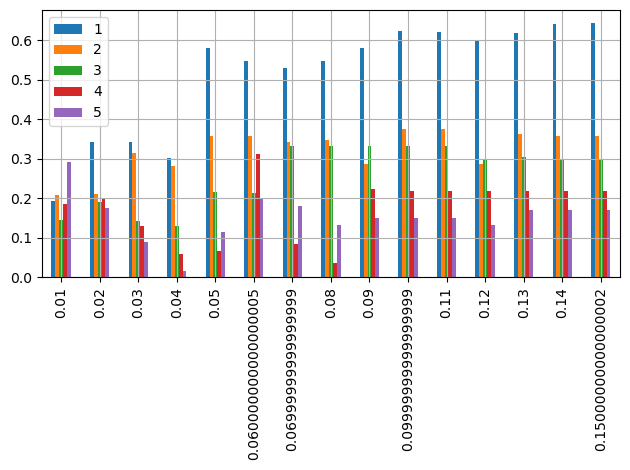

In [21]:
acc_results_df.plot(kind='bar',grid=True)
plt.tight_layout()
plt.show()

In [22]:
acc_results_df.to_csv(os.path.join('results','accuracy_10d_2017_2021.csv'))

Top-acc@k results

In [23]:
top_acc_results_df=pd.DataFrame(top_acc_results).T
top_acc_results_df = top_acc_results_df.fillna(0)
top_acc_results_df.head()

,1-1,5-1,5-2,5-3,5-4,5-5,11-1,11-2,11-3,11-4,...,13-4,13-5,13-6,13-7,13-8,13-9,13-10,13-11,13-12,13-13
0.01,0.193146,0.684211,0.000000,0.000000,0.0,0.0,0.857143,0.857143,0.857143,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,0.351234,0.794872,0.333333,0.102564,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.03,0.402619,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.04,0.335766,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.05,0.603226,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


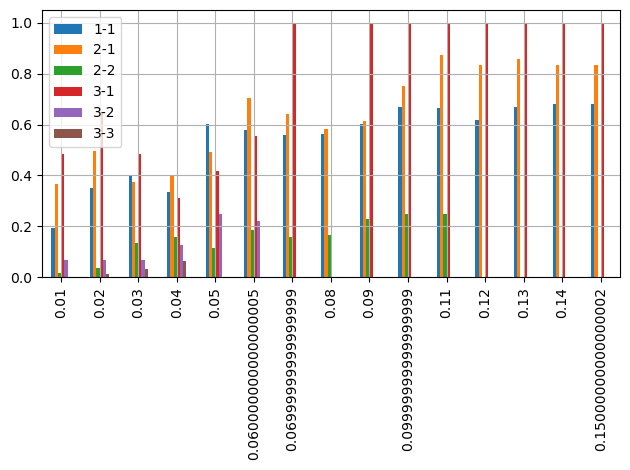

In [24]:
target_cols = '1-1 2-1 2-2 3-1 3-2 3-3'.split()
top_acc_results_df[target_cols].plot(kind='bar',grid=True)
plt.tight_layout()
plt.show()

In [25]:
top_acc_results_df.to_csv(os.path.join('results','top_accuracy_10d_2017_2021.csv'))

Database size results

In [26]:
database_size_df=pd.DataFrame(database_size_evol).T
database_size_df.head()

,2021-09-18,2021-09-19,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-25,2021-09-26,2021-09-27,...,2021-09-08,2021-09-09,2021-09-10,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17
0.01,72365.0,73609.0,74910.0,76553.0,77906.0,77920.0,79303.0,80682.0,80699.0,82058.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,24047.0,24065.0,24083.0,24148.0,24168.0,24177.0,24229.0,24277.0,24285.0,24310.0,...,23712.0,23717.0,23772.0,23814.0,23843.0,23877.0,23925.0,23970.0,23988.0,24024.0
0.03,11024.0,11033.0,11042.0,11063.0,11074.0,11077.0,11100.0,11119.0,11122.0,11133.0,...,10910.0,10911.0,10931.0,10939.0,10948.0,10960.0,10976.0,10989.0,10997.0,11014.0
0.04,NaN,NaN,NaN,7693.0,7694.0,7696.0,7705.0,7711.0,7713.0,7714.0,...,7644.0,NaN,7654.0,7658.0,7662.0,7668.0,7677.0,7681.0,7682.0,7687.0
0.05,NaN,NaN,NaN,5053.0,5054.0,5056.0,5059.0,NaN,5061.0,NaN,...,5039.0,NaN,5045.0,NaN,NaN,5046.0,5049.0,NaN,NaN,5052.0


In [27]:
database_size_df.to_csv(os.path.join('results','database_size_evol_10d_2017_2021.csv'))

Time-based accuracy results

In [28]:
date_acc_size_df=pd.DataFrame(all_dates_acc_results).T
date_acc_size_df.head()

,2021-09-18,2021-09-19,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-25,2021-09-26,2021-09-27,...,2021-09-08,2021-09-09,2021-09-10,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17
0.01,0.428571,NaN,0.333333,0.000000,0.0,0.000000,0.000000,0.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,1.000000,NaN,NaN,0.000000,0.0,0.500000,0.400000,0.0,1.0,0.0,...,0.0,0.0,0.600000,NaN,0.0,0.0,0.333333,0.0,1.0,0.666667
0.03,NaN,NaN,NaN,0.333333,0.5,0.666667,0.200000,0.0,1.0,0.5,...,0.0,0.0,0.333333,NaN,0.0,0.5,1.000000,0.0,0.0,0.285714
0.04,NaN,NaN,NaN,0.000000,0.0,0.000000,0.250000,0.0,1.0,0.0,...,0.0,NaN,0.200000,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000
0.05,NaN,NaN,NaN,1.000000,1.0,0.500000,0.333333,NaN,NaN,NaN,...,0.0,NaN,0.500000,NaN,NaN,1.0,1.000000,NaN,NaN,0.000000


In [29]:
date_acc_size_df.to_csv(os.path.join('results','date_acc_size_evol_10d_2017_2021.csv'))

Genre-based results

In [30]:
avg_genres_acc = {}
for t, genres_values in genres_acc_results.items():
    avg_t_val = {}
    
    for g, acc_values in genres_values.items():
        avg_t_val[g] = np.mean(acc_values)
    avg_genres_acc[t]= avg_t_val

In [31]:
genre_acc_df=pd.DataFrame(avg_genres_acc).T
genre_acc_df

,latin,hip-hop,rock,folk/traditional,pop,indie,miscellaneous,electronic,rythm and blues,classical and ost
0.01,0.750000,0.600000,0.000,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN
0.02,0.578947,0.133333,0.000,0.5,0.212766,0.142857,NaN,0.366667,0.318182,0.0
0.03,0.500000,0.121212,0.125,1.0,0.279070,0.500000,NaN,0.142857,0.142857,NaN
0.04,0.666667,0.119403,0.000,NaN,0.200000,1.000000,NaN,0.074074,0.142857,NaN
0.05,0.727273,0.550000,0.000,NaN,0.684211,1.000000,NaN,0.666667,0.333333,NaN
0.06,0.777778,0.653846,0.000,NaN,0.833333,1.000000,NaN,0.750000,1.000000,NaN
0.07,0.714286,0.692308,0.000,NaN,0.470588,NaN,NaN,0.428571,1.000000,NaN
0.08,1.000000,0.857143,0.000,NaN,0.454545,NaN,NaN,0.333333,1.000000,NaN
0.09,0.714286,0.869565,0.000,NaN,0.466667,NaN,NaN,0.714286,1.000000,NaN
0.10,1.000000,0.857143,0.000,NaN,0.363636,NaN,NaN,0.333333,1.000000,NaN


In [32]:
genre_acc_df.to_csv(os.path.join('results','genre_acc_10d_2017_2021.csv'))

In [33]:
print("That's all folks!")

That's all folks!
